In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from softsaftpy.constants import Na
from softsaftpy import softsaft, component

data_inp = '../../experimental/vapor_pressure/'

In [2]:
# from https://doi.org/10.1021/acs.jced.0c00588
pfpa = component(name='C4F9COOH', ms=2.403, sigma=4.550, eps=298.5, eAB=2200, kappaAB=2250, sites=[0, 1, 2], Mw=264.05)
eos = softsaft(pfpa, compute_critical=False)

In [3]:
T_exp1, P_exp1 = np.loadtxt(data_inp+'pfpa.txt', unpack=True, comments='#')
P_exp1 *= 1e-5
T_exp2, rhoL_exp2 = np.loadtxt('../../experimental/density/pfpa.txt', unpack=True, comments='#')

In [9]:
T_exp2, rhoL_exp2

(array([301.74, 311.84, 332.13, 352.63, 372.22]),
 array([1.6902, 1.6699, 1.6231, 1.5784, 1.5468]))

In [4]:
def fit_pfpa(inp):
    ms, sigma, eps = inp
    pfpa = component(name='C4F9COOH', ms=ms, sigma=sigma, eps=eps, eAB=2200, kappaAB=2250, sites=[0, 1, 2], Mw=264.05)
    eos = softsaft(pfpa, compute_critical=False)
    aad, aad_pt, aad_rho = 0, 0, 0
    for i,T in enumerate(T_exp1):
        P_eos = eos.psat(T)[0]*1e-5
        aad_pt += np.abs((P_eos - P_exp1[i])/P_exp1[i])
    aad_pt *= 100/len(T_exp1)
    for i,T in enumerate(T_exp2):
        rhoL_eos = eos.density(T, 101325, 'L') * pfpa.Mw/1e6
        aad_rho += np.abs((rhoL_eos - rhoL_exp2[i])/rhoL_exp2[i])
    aad_rho *= 100/len(T_exp2)
    aad = (aad_pt + aad_rho)/2
    print(f'ms={ms:.3f}, sigma={sigma:.3f}, eps={eps:.3f} -> AAD_P={aad_pt:.2f}%, AAD_rho={aad_rho:.2f}%, AAD={aad:.2f}%')
    return aad
#res = minimize(fit_pfpa, [2.403, 4.550, 298.5], method='Nelder-Mead', options={'xatol':1e-3, 'disp':True})

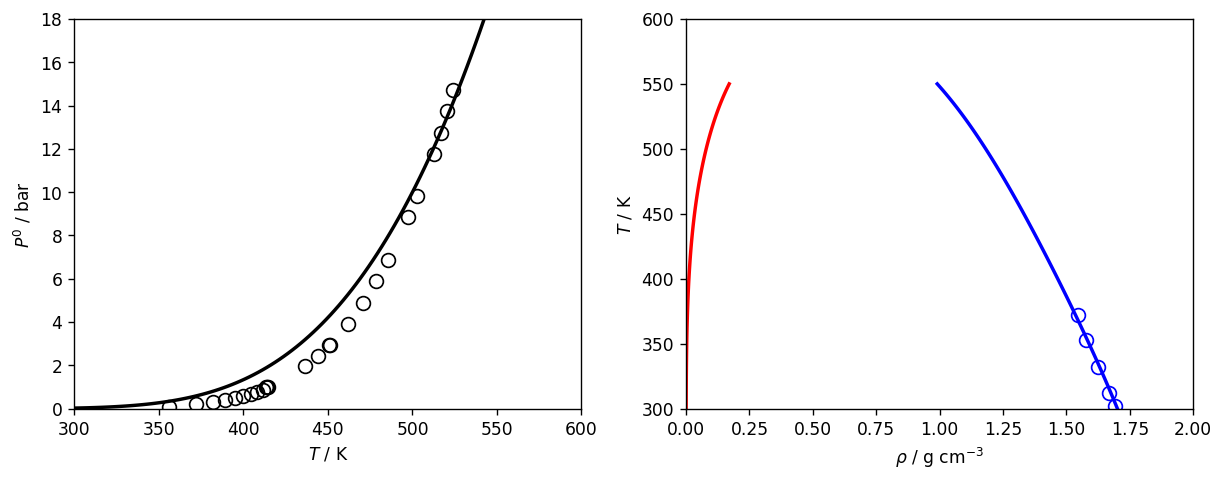

In [5]:
#pfpa = component(name='C4F9COOH', ms=res.x[0], sigma=res.x[1], eps=res.x[2], eAB=2200, kappaAB=2250, sites=[0, 1, 2], Mw=264.05)
#eos = softsaft(pfpa, compute_critical=True)

T_vec = np.linspace(300, 550, 100)
P_vec = np.zeros_like(T_vec)
rhoL_vec, rhoV_vec = np.zeros_like(T_vec), np.zeros_like(T_vec)
for i,T in enumerate(T_vec):
    out = eos.psat(T)
    #P_vec[i], rhoL_vec[i], rhoV_vec[i] = eos.psat(T)
    P_vec[i] = out[0]*1e-5
    rhoL_vec[i] = 1./out[1]*pfpa.Mw/1e6
    rhoV_vec[i] = 1./out[2]*pfpa.Mw/1e6

plt.figure(figsize=(10,4), dpi=123.7)
plt.subplot(1,2,1)
plt.plot(T_exp1, P_exp1, 'ok', ms=8, mfc='none')
plt.plot(T_vec, P_vec, '-k', linewidth=2)

plt.xlabel(r'$T$ / K'), plt.ylabel(r'$P^0$ / bar')
plt.xlim(300, 600), plt.ylim(0, 18)
plt.subplot(1,2,2)
plt.plot(rhoL_vec, T_vec, '-b', linewidth=2, label='liquid')
plt.plot(rhoV_vec, T_vec, '-r', linewidth=2, label='vapor')
plt.plot(rhoL_exp2, T_exp2, 'ob', ms=8, mfc='none')
plt.xlabel(r'$\rho$ / g cm$^{-3}$'), plt.ylabel(r'$T$ / K')
plt.xlim(0, 2), plt.ylim(300, 600)
plt.tight_layout()
plt.show()

In [14]:
# Estimation of equilibrium conditions for MD simulations
T_MD = np.array([300., 340., 380.])
P_MD = np.zeros_like(T_MD)
rhoL_MD, rhoV_MD = np.zeros_like(T_MD), np.zeros_like(T_MD)
for i,T in enumerate(T_MD):
    out = eos.psat(T)
    P_MD[i] = out[0]*1e-5
    rhoL_MD[i] = 1./out[1]*pfpa.Mw/1e6
    rhoV_MD[i] = 1./out[2]*pfpa.Mw/1e6
    #print(f'T={T_MD[i]:.1f} K: P={P_MD[i]:.3f} bar, rhoL={rhoL_MD[i]:.4f} g/cm3, rhoV={rhoV_MD[i]:.4f} g/cm3')

Lx = 50.0  # Angstrom
Ly = Lx
Lz = 7.5*Lx
NL_MD, NV_MD = np.zeros_like(T_MD), np.zeros_like(T_MD)
for i in range(len(T_MD)):
    NL_MD[i] = rhoL_MD[i]*1e6/pfpa.Mw*Na*Lx*Ly*Lz/3*1e-30
    NV_MD[i] = rhoV_MD[i]*1e6/pfpa.Mw*Na*Lx*Ly*Lz/3*1e-30
    print(f'T={T_MD[i]:.1f} K: NL={NL_MD[i]:.2f}, NV={NV_MD[i]:.2f}, P={P_MD[i]:.3f} bar')

T=300.0 K: NL=1212.38, NV=0.19, P=0.026 bar
T=340.0 K: NL=1149.37, NV=1.22, P=0.182 bar
T=380.0 K: NL=1080.63, NV=4.65, P=0.755 bar
